# Tree Plotting   -- IN PROGRESS --

Nous allons travailler sur les represenations graphique d'arbres.
Ces arbres seront des arbres de termes GO après:
* Analyse ORA aura été appliquée
* Disparition des sous arbres non-porteurs de feuille protéines **S**ur**A**bondantes 

##### IFB Virtual Machine Configuration

* `rootDir` points to Jupyter Home Directory
* `projectDir` points to the Git project, holds the *tsv* file
* `libDir` points to Git project python library with files names `go.py  stat_utils.py  uniprot.py`
* `dataDir` points to shared data folder with uniprot and GO files

In [ ]:
import sys

rootDir = "//ifb/data/mydatalocal"
projectDir = rootDir + "/VDBscratch"
libDir = projectDir + "/lib"
dataDir= "/ifb/data/public/teachdata/m2binf_ucbl/data" 

sys.path.append(libDir)

In [ ]:
import pandas, uniprot, go
import numpy as np
from stat_utils import computeORA_BKG

In [ ]:
%matplotlib nbagg
import matplotlib.pyplot as plt

### Extraction de la liste de protéines SurAbondantes
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
###### Rappel
Pour faciliter le développement nous considerereons comme **S**ur**A**bondante toute protéine à **Log2 Corrected Abundance Ratio** supérieur à 0.
###### A faire
* Retirer les lignes présentant des aberrations numériques
* Créer une DataFrame ne contenant que les lignes où **Log2 Corrected Abundance Ratio** > 0

In [12]:
import pandas
df = pandas.read_csv(projectDir + "/TCL_wt1.tsv", delimiter ="\t")
dfClean = df[ (df['Log2 Corrected Abundance Ratio'] != '#VALEUR!') & (df['LOG10 Adj.P-val'] != '#VALEUR!')]
dfClean = dfClean.copy()
dfClean.loc[:,'Log2 Corrected Abundance Ratio'] = dfClean.loc[:,'Log2 Corrected Abundance Ratio'].astype(float)

saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
print(f"La liste de protéines SurAbondantes est de taille {len(saList)}")

La liste de protéines SurAbondantes est de taille 44


# Definitions de pathway fonctionels: manipulation de l'ontologie


##### Chargement des données uniprot et GO

In [14]:
uniprotCollection = uniprot.UniprotCollection(dataDir +"/dataset")
K12 = uniprot.UniprotCollection(dataDir + "/K12_proteome/")
print("Loading ontology")
go.setOntology(dataDir + "/go.owl")

Loading ontology
Loaded


##### Décommentez les quatre commandes du namespace de votre choix

In [15]:
xpProtList = dfClean['Accession'].tolist()

print("Extracting biological process ontology")
xpGoTree_BP = go.AnnotationTree("biological process", collapse=True)
xpGoTree_BP.extract(xpProtList, uniprotCollection)

fullEcoliGoTree_BP = go.AnnotationTree("biological process", collapse=True)
fullEcoliGoTree_BP.extract(K12.list, K12)

#print("Extracting molecular function ontology")
#xpGoTree_MF = go.AnnotationTree("molecular function", collapse=True)
#xpGoTree_MF.extract(xpProtList, uniprotCollection)

#fullEcoliGoTree_MF = go.AnnotationTree("molecular function", collapse=True)
#fullEcoliGoTree_MF.extract(K12.list, K12)

#print("Extracting cellular component ontology")
#xpGoTree_CC = go.AnnotationTree("cellular component", collapse=True)
#xpGoTree_CC.extract(xpProtList, uniprotCollection)

#fullEcoliGoTree_CC = go.AnnotationTree("cellular component", collapse=True)
#fullEcoliGoTree_CC.extract(K12.list, K12)

Extracting biological process ontology
Applying true path collapsing
2194 leaves, 3482 nodes, 1474 proteins
Applying true path collapsing
2728 leaves, 6650 nodes, 3128 proteins


## RAPPELS

### AnnotationTree est l'arbre des annotations GO portées par une collection de proteines 

#### Un arbre ne rend compte que d'un seul namespace GO
On définit le namespaced des termes GO à extraire par un de ces trois termes : 
* "biological process", "molecular function", "cellular component"
 
```python
aTree = go.AnnotationTree("biological process", collapse=True)
```
On ne garde dans cet arbre que les termes portés par les protéines données en dernier argument
```python
aTree.read_DAG(['P75936', 'P76231', 'P0A8S9'], uniprotCollection)
```

### API de l'arbre d'annotations


#### Taille de l'abre
```python
aTree.dimensions
```

#### Extraire un sous arbre
```python
bTree = aTree.newRoot("transmembrane transport")
```

#### Enumerer les protéines porteuses de termes GO

##### Dans tout l'arbre
```python
proteinList = aTree.getMembers()
```
##### A partir d'un noeud
```python
proteinList = aTree.getMembersByName("transmembrane transport")
proteinList = aTree.getMembersByID("GO:0055085")
```

#### Acceder directement à un noeud
```python
goTerm = aTree.getByName("transmembrane transport")
goTerm = aTree.getByID("GO:0055085")
```

#### Elager un arbre
Retirer tous les noeuds n'ayant aucun des éléments suivants parmi leurs protéines annotées

```python
def predicat(goTerm):
    return set(goTerm.getMembers()) & set(['P75936', 'P76231', 'P0A8S9'])

bTree = aTree.drop(predicat)
```

## Analyse de la surreprésentation

Le package *stat_utils.py* permet d'appliquer L'analyse de surreprésentation récursivement, en profondeur, à partir d'un terme GO racine.

#### Estimation récursive des enrichissements

* Choix du terme GO général
```python
pathWayRoot = xpGoTree.getByName("transmembrane transport")
```

* Définition du terme GO regroupant tout le protéome
```python
pathWayBKG = fullEcoliGoTree.getByName("biological process")
```

* Calcul de l'enrichissement en termes GO successifs parmi les protéines surabondantes (ici, *saList*)
```python
oraFisher, oraCDF = computeORA_BKG(pathWayRoot, saList, pathWayBKG)
```
* Des arbres peuvent également être passés.
```python
tm_transport_GoTree = xpGoTree.newRoot("transmembrane transport")
oraFisher, oraCDF = computeORA_BKG(tm_transport_GoTree, saList, fullEcoliGoTree)
```

## Visualisation des arbres
Nous allons maintenant représenter la hiérarchie des termes GO portés par les protéines surreprésentées.
Dans un premier temps, il vous est conseillé de vous placer à un niveau suffisamment bas dans l'arbre pour constuire la visualisation avec peu de feuilles.

##### Elagage de l'arboresence GO
Nous souhaitons, éliminer les branches de l'arbre ne comportant aucune protéine surreprésentées.
On peut facilement obtenir toutes les protéines sous un terme GO donné, via l'API de l'arbre ou du terme GO.
```python
# Recupere depuis l'arbre toutes les occurences de protéines sous le noeud "intracellular part"
proteinIdList = aTree.getMembersByNames("intracellular part")
# Recupere le noeud "intracellular part" depuis l'arbre, puis toutes les occurences de protéines sous celui-ci
GOterm = aTree.getByNames("intracellular part")
_proteinIdList = GOTerm.getMembers()
set(_proteinIdList) == set(proteinIdList) # -> True
```

L'API arbre fournit la méthode **drop**, qui prend en argument une fonction prédicat qui sera appliquée récursivement à chaque terme de l'arbre. 
* Le prédicat recoit un unique argument, le terme à évaluer.
* Le prédicat doit retourner un booléen. 
* Si le prédicat retourne faux, le noeud évalué (ainsi que son sous-arbre) sera supprimé ("droped")

In [16]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()

def fn(node):
    return set(node.getMembers()) & set(saList)

dTree = xpGoTree_CC.drop(fn)
print(f"{xpGoTree_CC.dimensions} -> {dTree.dimensions}")

(209, 2324, 1426) -> (53, 1999, 1388)


### ete3

La librairie [ete3](http://etetoolkit.org/) est une solution rapide pour déssiner des arbres en Python. 
Son intégration à [Jupyter](http://etetoolkit.org/ipython_notebook/) va vous permettre de dessiner la hiérarchie de termes GO portées par les protéines surreprésentées. Libre à vous d'essayer les différents ["layout"](http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#circular-tree-in-180-degrees)

### amélioration

Vous observerez que les arbres de termes GO des études experimentales ont été modifiés lors de l'analyse d'enrichissement. Chacun de leurs noeuds sont desormais porteurs:
* d'une p-value d'enrichissement : `aTree.getByName("pore complex").Fisher`
* d'une liste de protéines effectivement annotées : `aTree.getByName("pore complex").eTag`

Les proteines annotées par ce terme ou ses descendants sont toujours accessibles: `set( aTree.getMembersByName("pore complex") )`

Vous pouvez rendre compte de ses valeurs en modifiant couleurs et tailles des noeuds correspondant dans la représentation graphique.

In [17]:
from ete3 import Tree, TreeStyle, NodeStyle
def drawRadial(viewTree):
    t = Tree(viewTree.as_newick(), format=8, quoted_node_names=True)
    #t.populate(30)
    ts = TreeStyle()
    ts.show_leaf_name = True
    ts.mode = "c"
    ts.arc_start = -180 # 0 degrees = 3 o'clock
    ts.arc_span = 270

    for n in t.traverse():
        if n.name == "":
            continue
        node = viewTree.getByName(n.name)
        nstyle = NodeStyle()

        if not node:
            print("->", n.name) 
        elif node.name == 'root':
            nstyle["fgcolor"] = "black"
        else :
            nstyle["fgcolor"] = "darkred" if len(node.eTag) > 0 else "steelblue"

        n.set_style(nstyle)
    return t.render(file_name="%%inline", w=1200, tree_style=ts)

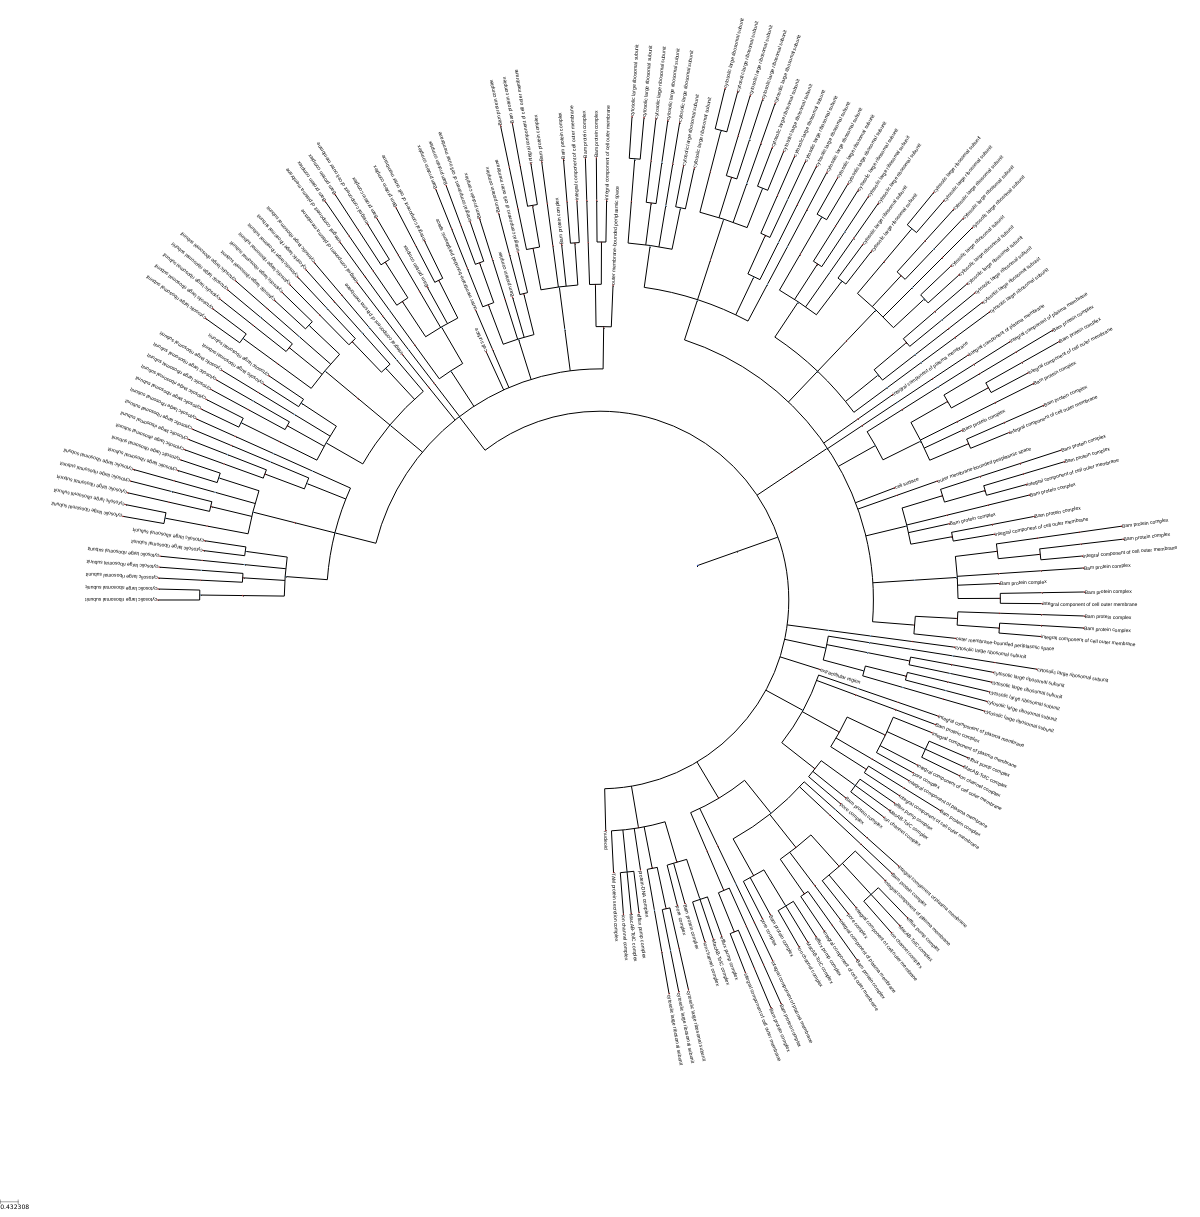

In [18]:
drawRadial(dTree)

In [100]:
import matplotlib
l=[ n.leafCount   for n in viewTree.traverse() ]
c_cmap = plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm([ wMin, np.percentile(l,25), np.percentile(l,50), np.percentile(l,75), wMax ], c_cmap.N)


In [392]:
c_cmap(norm(10))

(0.8333333333333333, 0.8660254037844388, 0.5000000000000001, 1.0)

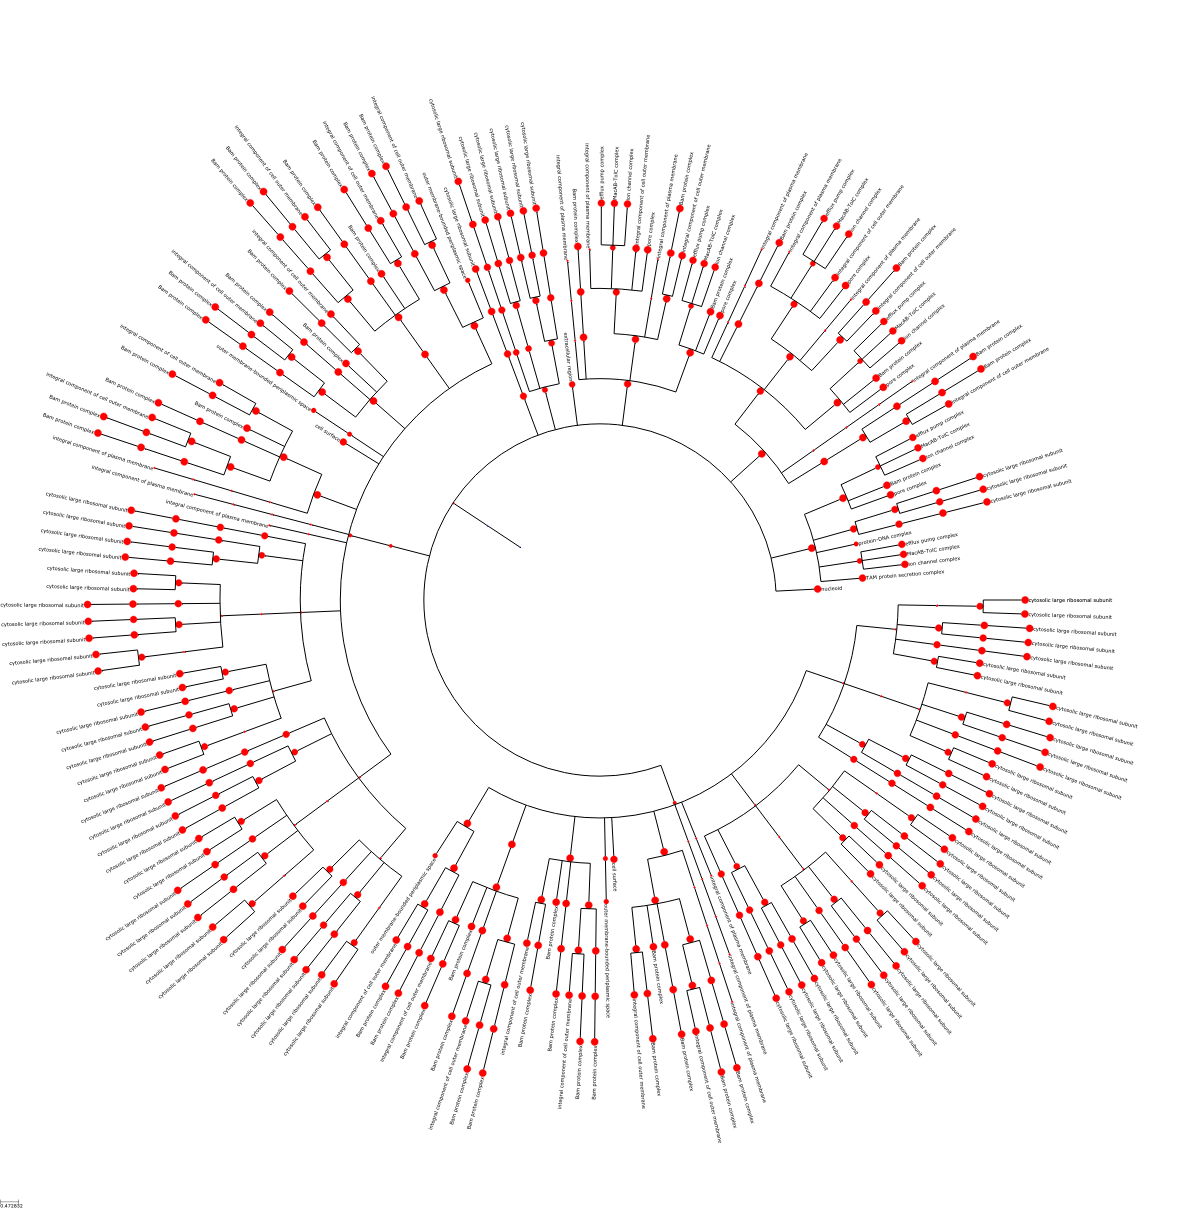

In [101]:
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace

import matplotlib.pyplot as plt
import matplotlib.colors as co

viewTree = dTree

wMin = min([ n.leafCount   for n in viewTree.traverse() ])
wMax = max([ n.leafCount   for n in viewTree.traverse() ])

[ n.leafCount   for n in viewTree.traverse() ]

def categoricalColorScale(value):
    v = c_cmap(norm(value))
    _v = co.ColorConverter.to_rgb(v)
    s = '%02x%02x%02x' % (int(_v[0]*255), int(_v[1]*255), int(_v[2]*255))
    #print(value, s)
    #print(_v)
    return f"#{s}"

def colorScale(value):
    #print (">>", value, wMin, wMax, "<<")
    norm = co.Normalize(vmin=wMin, vmax=wMax)
    cmap = plt.cm.winter
    v = cmap( norm(value) )
    #print(v)
    _v = co.ColorConverter.to_rgb(v)
    
    s = '%02x%02x%02x' % (int(_v[0]*255), int(_v[1]*255), int(_v[2]*255))
    #print(value, s)
    #print(_v)
    return f"#{s}"

def radiusScale(t):
    maxRadius, minRadius = (20, 5)
    return t *(minRadius - maxRadius) + maxRadius

def layout(node):
    if node.is_leaf():
        # Add node name to laef nodes
        N = AttrFace("name", fsize=14, fgcolor="black")
        faces.add_face_to_node(N, node, 0)
    return 
    
    
    if "weight" in node.features:
        # Creates a sphere face whose size is proportional to node's
        # feature "weight"
     #   col = colorScale(node.fisher)
        col = colorScale(node.weight)
        w = (1 - node.fisher) * 10
  #      print (col)
        #  C = CircleFace(radius=node.weight, color=QColor(*col), style="sphere")
#        C = CircleFace(radius=w, color=QColor(*col), style="sphere")
        C = CircleFace(radius=w, color=col, style="sphere")
        
        # Let's make the sphere transparent
        C.opacity = 0.3
        # And place as a float face over the tree
        #faces.add_face_to_node(C, node, 0, position="float")
t = Tree(viewTree.as_newick(), format=8, quoted_node_names=False)

for n in t.traverse():
    if n.name == "":
        continue
        
    node = viewTree.getByName(n.name)
   
    if not node:
        raise KeyError("Oups")
    if node.name == 'root':
        continue
    
    #print (node)
    
    w = node.leafCount
    #print ("-->", w)
    f = 1.0
    try:
        f = getattr(node, 'Fisher')
    except AttributeError:
        pass
    
    nstyle = NodeStyle()
    
    nstyle["fgcolor"] = categoricalColorScale(w)
    #print(node)
    nstyle["size"] = radiusScale(node.Fisher)

    n.set_style(nstyle)
    
    n.add_features(weight=w, fisher = f)

# Create an empty TreeStyle
ts = TreeStyle()

# Set our custom layout function
ts.layout_fn = layout

# Draw a tree
ts.mode = "c"

# We will add node names manually
ts.show_leaf_name = False
# Show branch data
ts.show_branch_length = False
ts.show_branch_support = False

t.render(file_name="%%inline", w=1200, tree_style=ts)


#### Visualisation des abondances et Pathway pour chaque protéine
Nous allons représenter la relation entre l'abondance des protéines (**Log2 Corrected Abundance Ratio**)  et la précision de la mesure (**LOG10 Adj.P-val**). Ceci se fera à l'aide de la commande matplotlibb [scatter](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html).
###### Volcano Plot global
* Creer la fonction drawScatter(abundanceList, precisionList) qui produira le graphique.
* Creer la fonction drawScatterPathway(goTermsList) 
    * Unique argument qui est une liste n goTerm aux p-value les plus faibles.
    * Dessine les protéines annotées par ces termes GO
    * Colorie de la même couleur, les protéines du même pathway
    * Si une protéine appartient à différents pathway, la priorité ira à celui de p-value la plus faible.

Au maximum 20 pathways pourront être représentés simultanément, vous utiliserez les [cartes de couleurs catégorielles](https://matplotlib.org/examples/color/colormaps_reference.html)

######  Volcano Plot interactif

Il serait plus intéressant de colorier les protéines d'un pathway donné à la volée, en mettant à jour le scatter plot à chaque fois. Jupyter fournit une libraire de composant interactif appelés [widgets](https://ipywidgets.readthedocs.io/en/stable/user_guide.html). 

* Construisez un widget `Dropdown` listant les pathway.


<IPython.core.display.Javascript object>


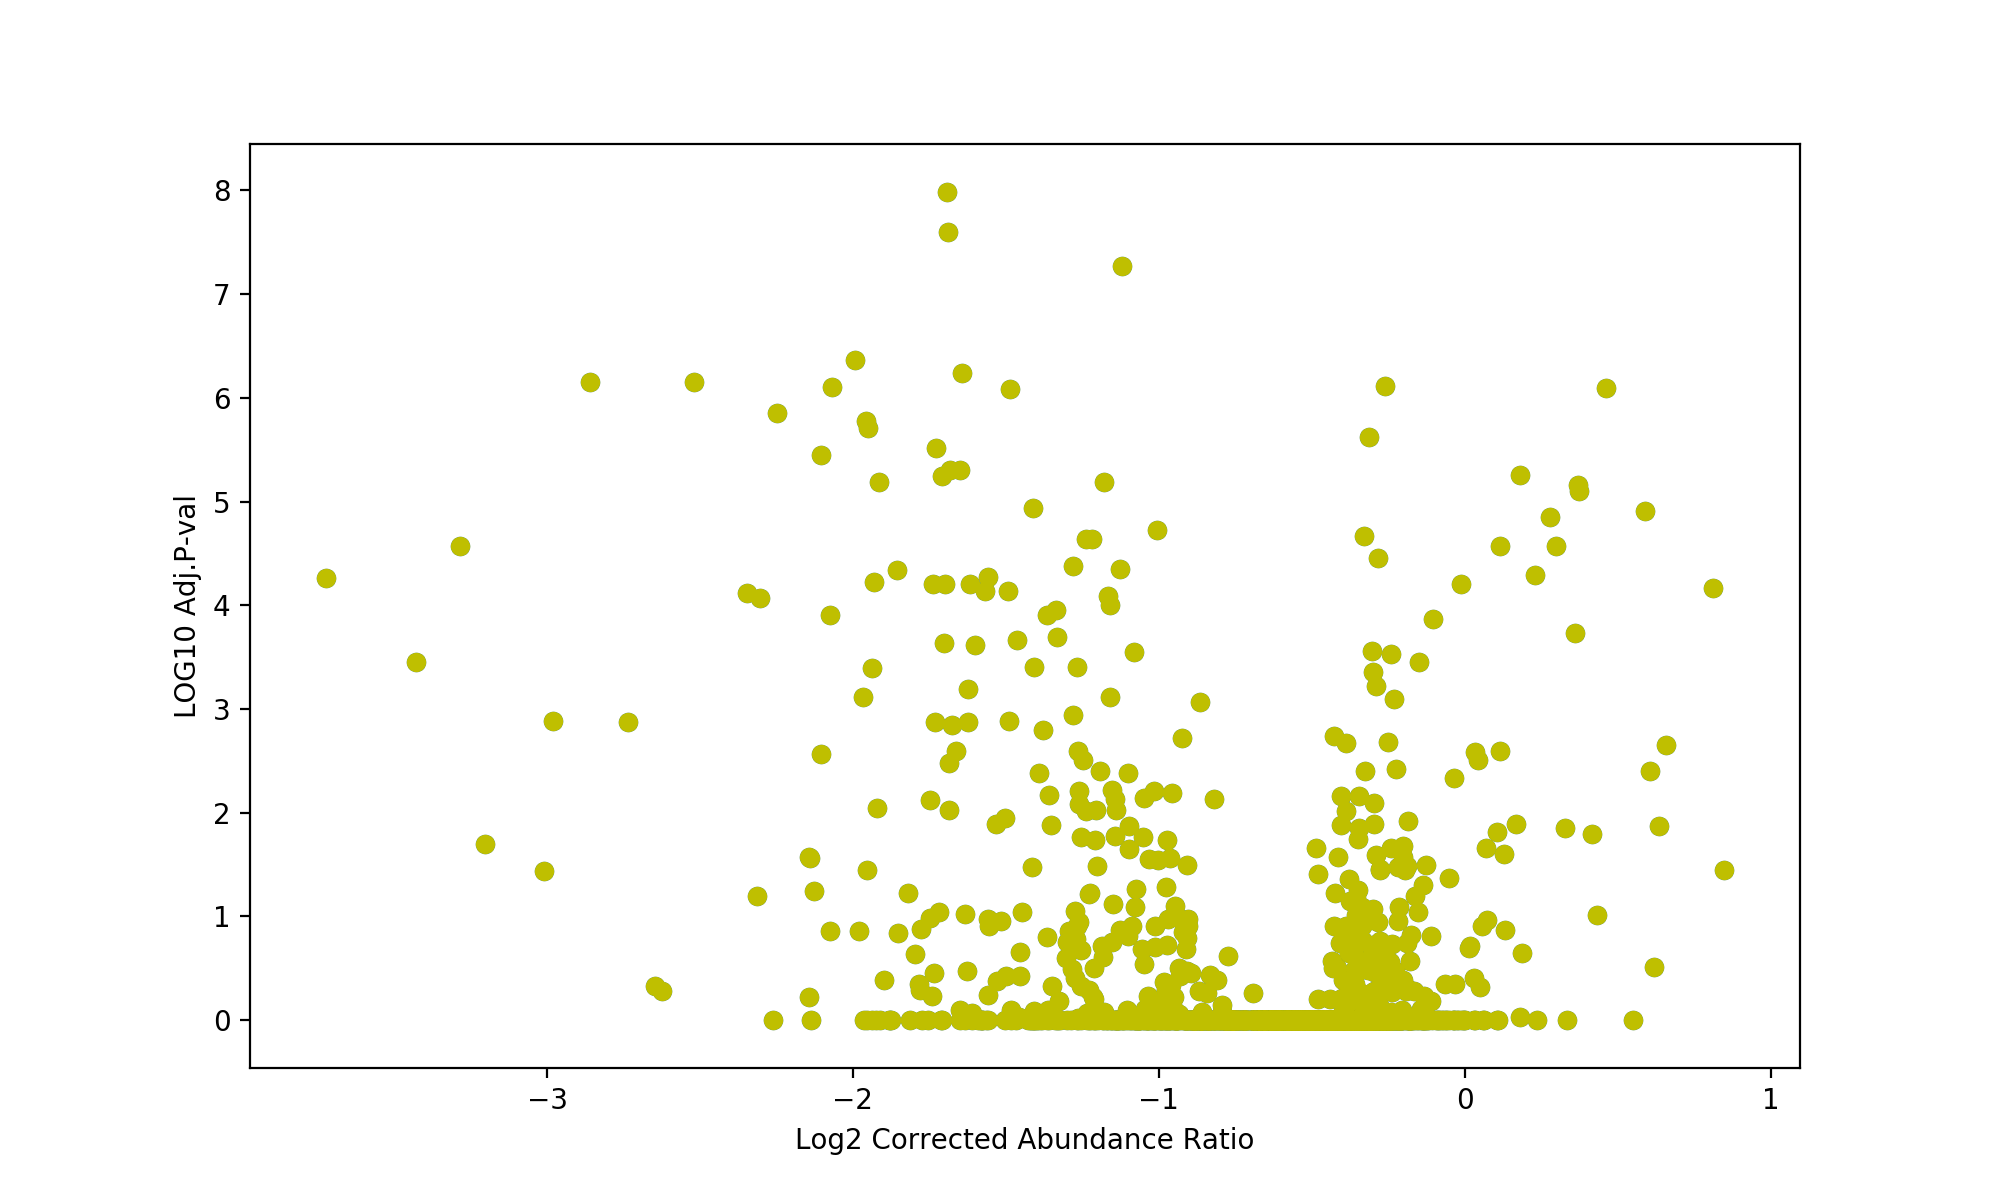

In [7]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
x = [ float(i) for i in dfClean['Log2 Corrected Abundance Ratio'].tolist() ]
y = [ float(i) for i in dfClean['LOG10 Adj.P-val'].tolist() ]
labels = dfClean['Accession'].tolist()
def drawScatter(x, y):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.yticks(np.arange(min(y), max(y)+1, 1.0))
    plt.scatter(x, y)
    scat = ax.scatter(x, y, color='y', picker=5)
    plt.ylabel('LOG10 Adj.P-val')
    plt.xlabel('Log2 Corrected Abundance Ratio')
    return scat, fig, ax
    
scat, fig, ax = drawScatter(x,y)

Dropdown(description='Clicks select:', options=('PathwayX', 'PathwayY', 'Pathway Z'), value='PathwayX')

FloatRangeSlider(value=(5.0, 7.5), continuous_update=False, description='Test:', max=10.0, readout_format='.1f…

<IPython.core.display.Javascript object>


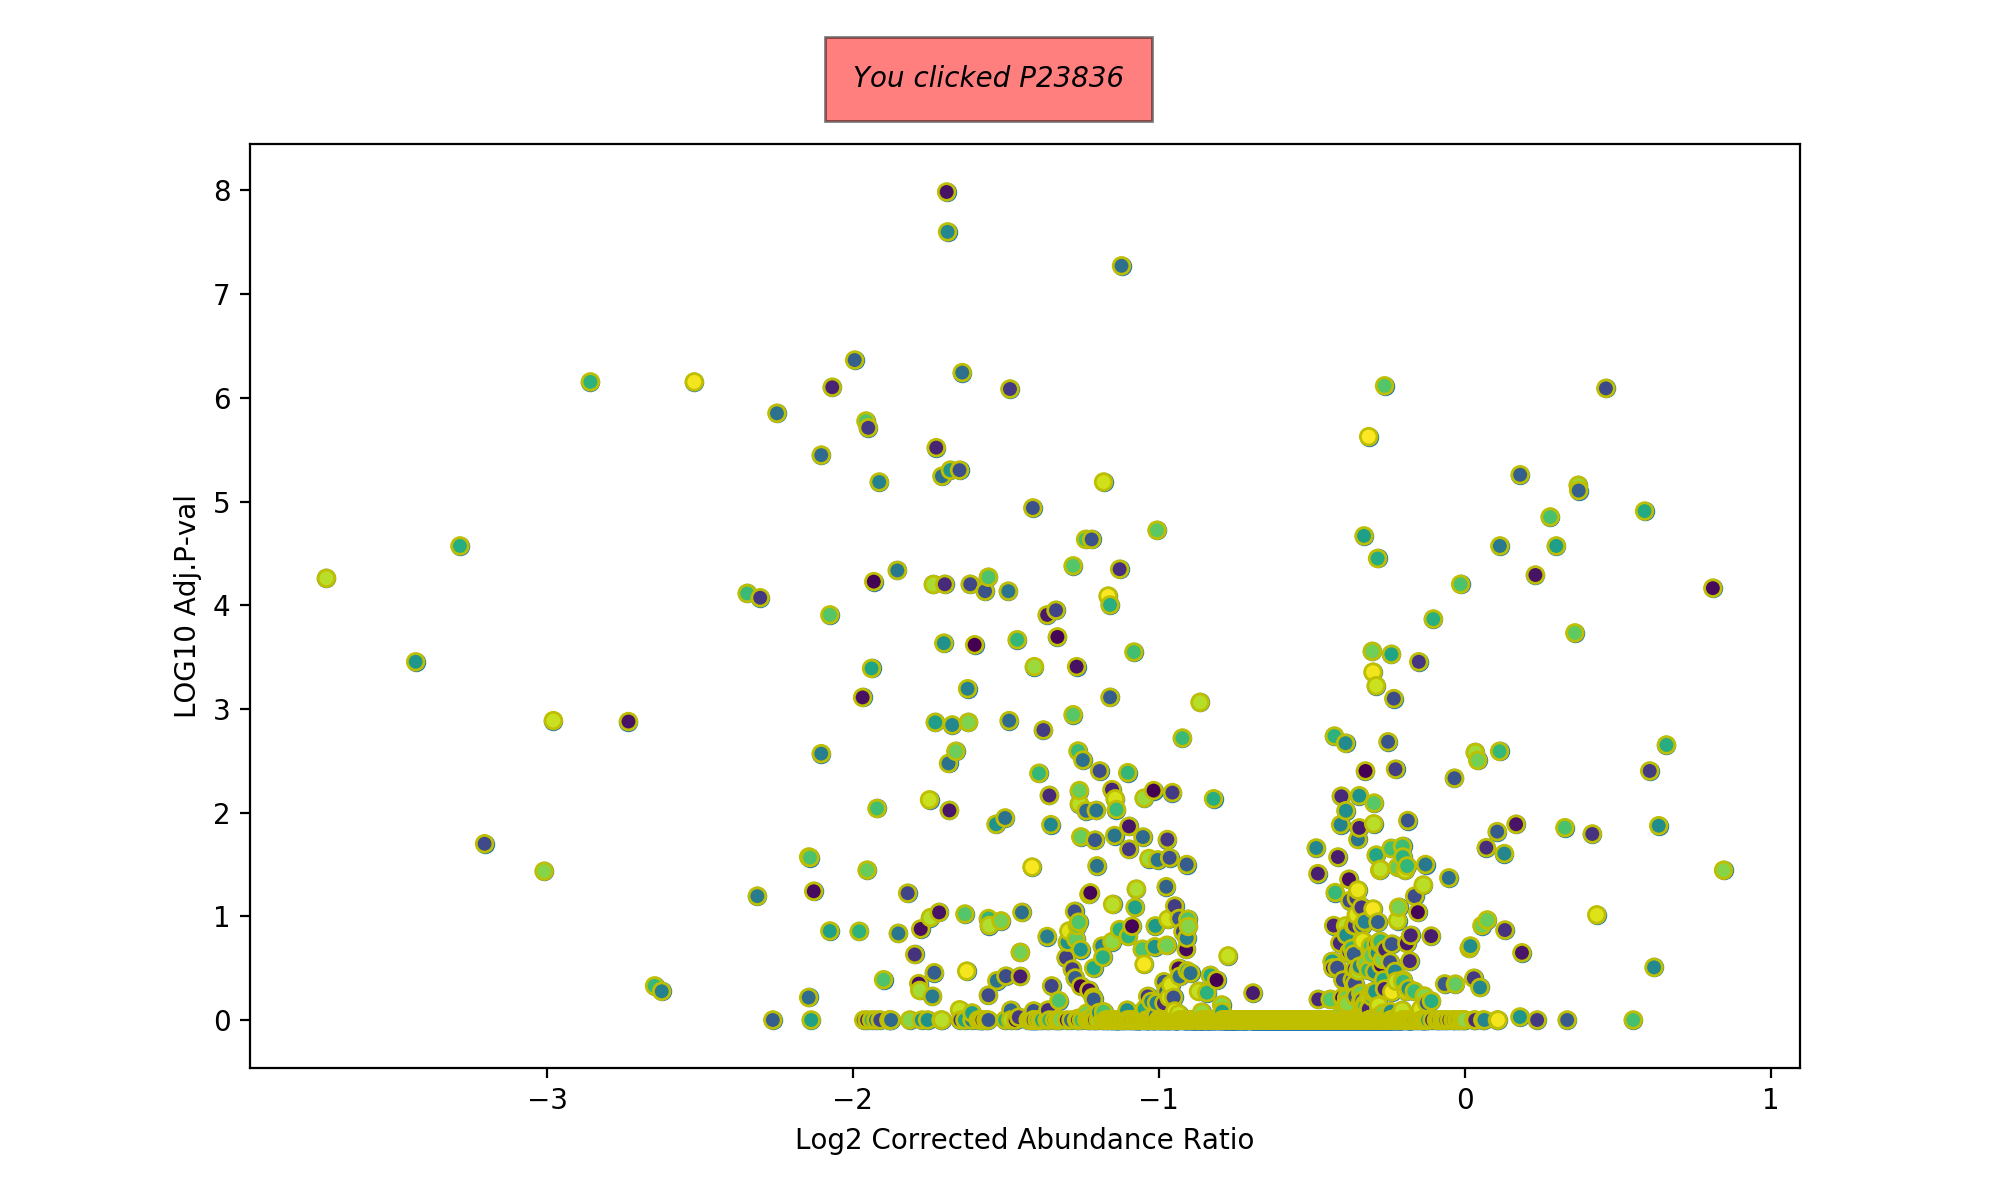

9

--> PathwayY
--> Pathway Z


In [8]:
#https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
# https://stackoverflow.com/questions/7908636/possible-to-make-labels-appear-when-hovering-over-a-point-in-matplotlib
%matplotlib notebook
#plt.close('all')
#matplotlib.use('nbagg')

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

# Define the content of the Dropdown list
selWidget = widgets.Dropdown(description='Clicks select:', 
                             value= 'PathwayX', options=('PathwayX', 'PathwayY', 'Pathway Z') 
                            )

rsWidget = widgets.FloatSlider(
    value=7.5,
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
rsWidget = widgets.FloatRangeSlider(
    value=[5, 7.5],
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

# Define the behaviour on list change     
def on_value_change(change):
    print("-->", change["new"])
    scat.set_array( np.random.random(len(x)) )

    txtBox.set_text(change["new"])
    fig.canvas.draw_idle()

def on_event(event):
    ind = event.ind[0]
    artist = event.artist
    #d = otherdata[scatters.index(artist)]
    
    
    scat.set_array( np.random.random(len(x)) )

    txtBox.set_text("You clicked {}".format(labels[ind]))

    fig.canvas.draw()
    fig.canvas.draw_idle()

def _onpick(event):
    ind = event.ind[0]
    artist = event.artist
    d = otherdata[scatters.index(artist)]
    scat.set_array( np.random.random(len(x)) )

    txtBox.set_text("You clicked {}".format(d[ind]))
    fig.canvas.draw_idle()
        #on_value_change({'new': 'toto'})
        
        
# Bind the change function to the list widget, display the widget    
selWidget.observe(on_value_change, names='value')
display(selWidget, rsWidget)

# Draw the figure in its initial state

x = [ float(i) for i in dfClean['Log2 Corrected Abundance Ratio'].tolist() ]
y = [ float(i) for i in dfClean['LOG10 Adj.P-val'].tolist() ]

scat,fig,ax = drawScatter(x, y)

txtBox = ax.text(-2, 9, 'boxed italics text in data coords', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})


fig.canvas.mpl_connect('pick_event', on_event)
fig.canvas.mpl_connect('key_press_event', on_event)

#plt.show()

<IPython.core.display.Javascript object>


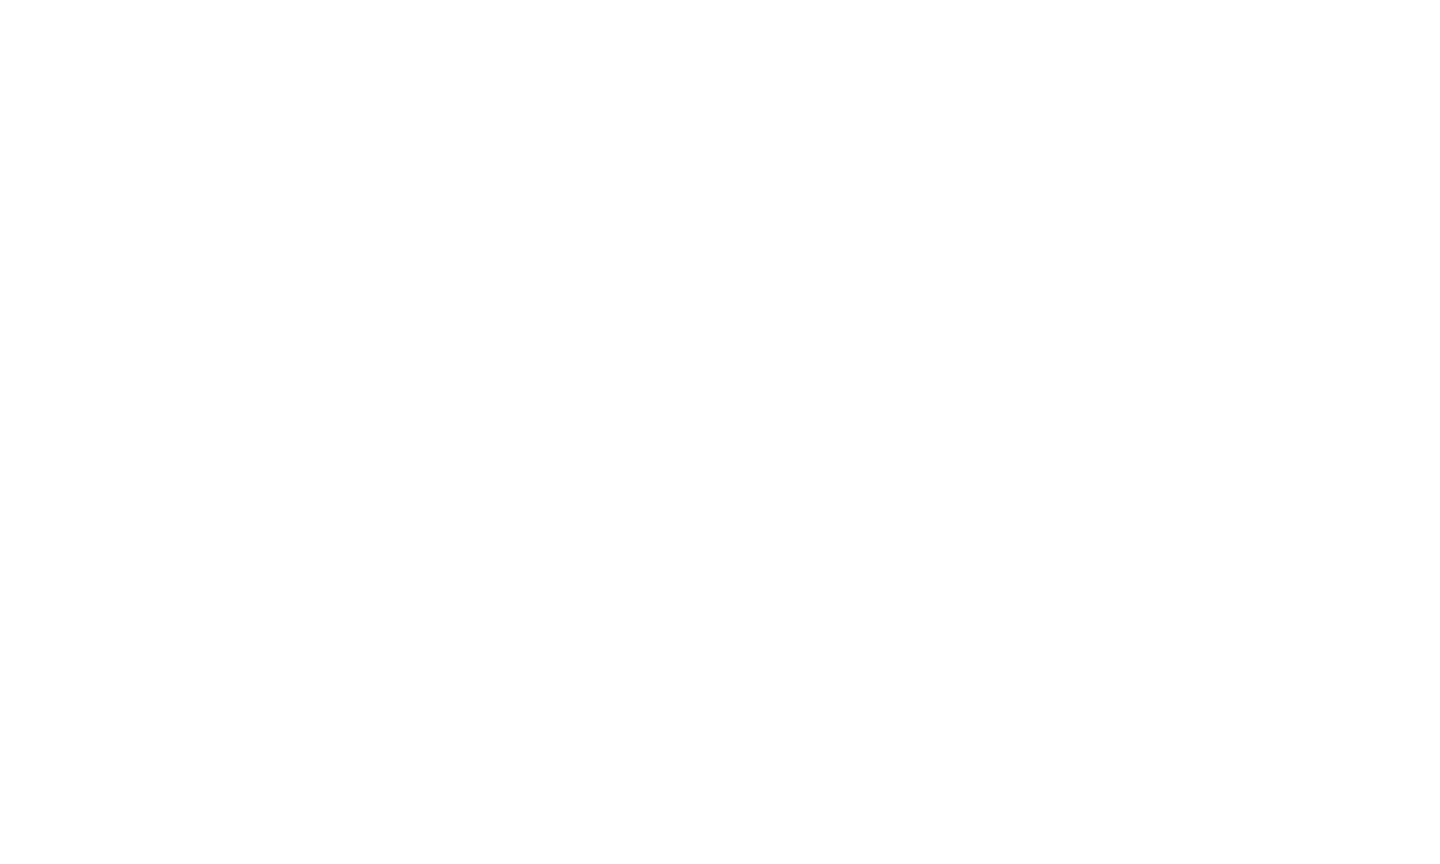

<IPython.core.display.Javascript object>


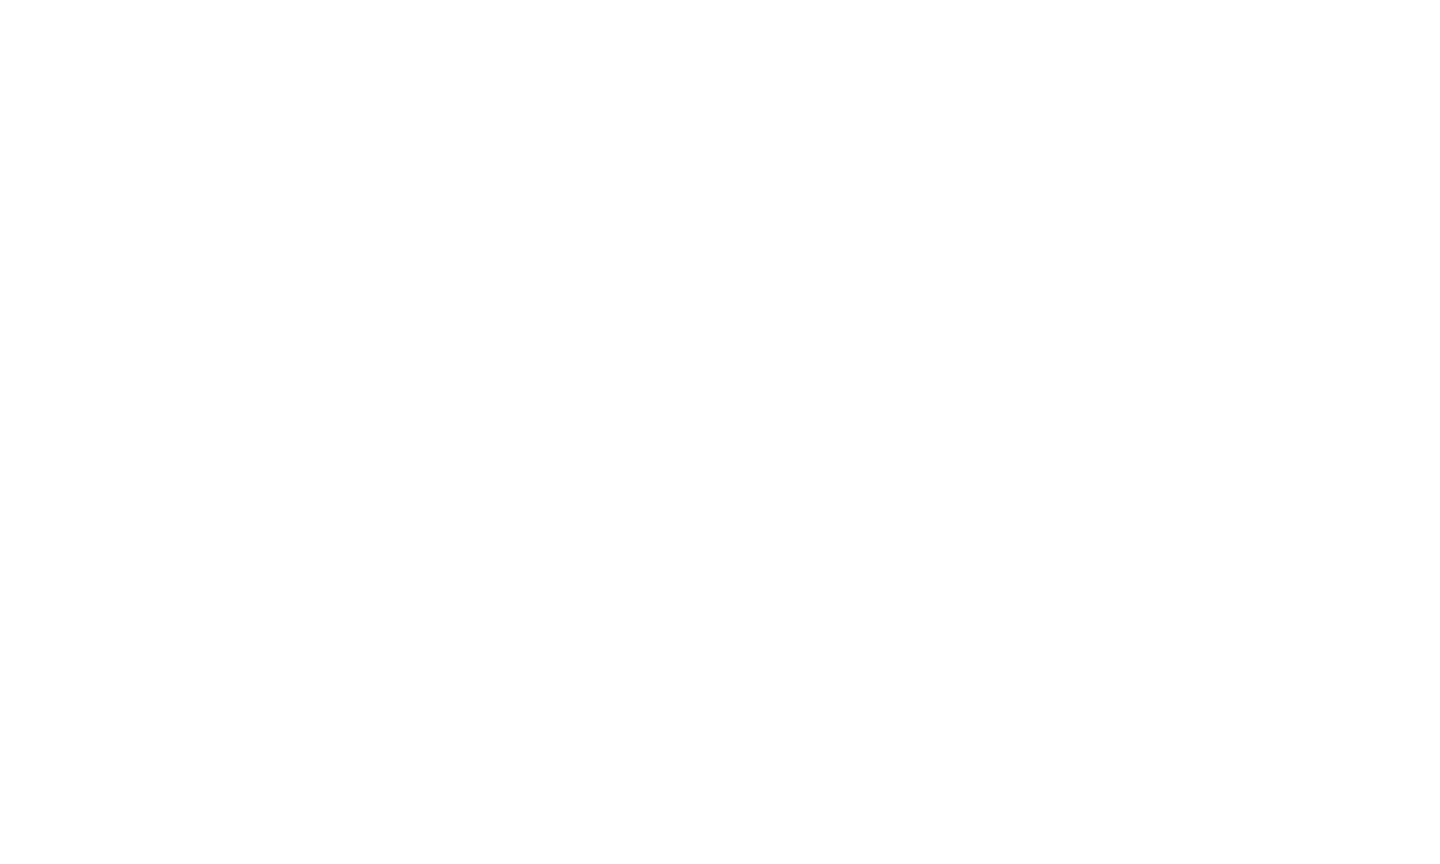

In [131]:
scat,fig,ax = drawScatter(x, y)

In [45]:
plt.get_backend()

'nbAgg'

<IPython.core.display.Javascript object>


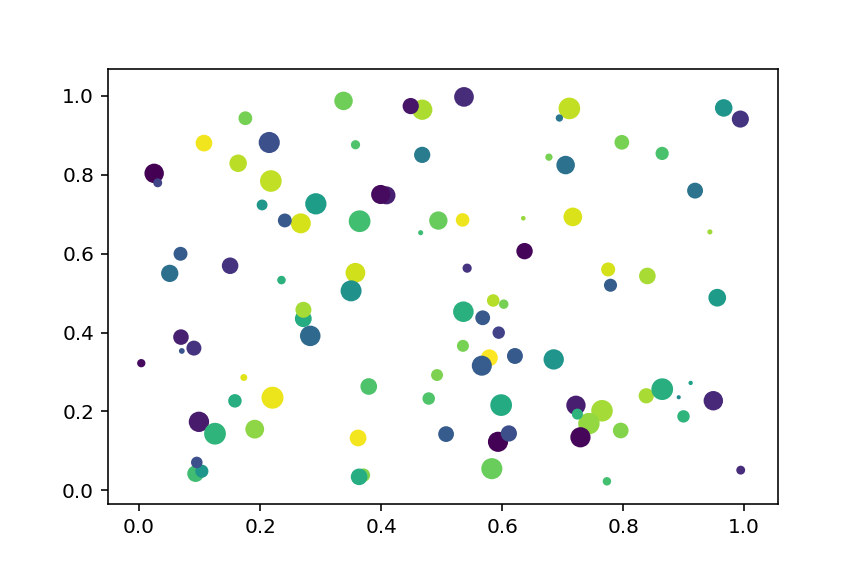

In [15]:
#%matplotlib widget
import matplotlib.pyplot

from matplotlib.pyplot import figure, show
import numpy as npy
from numpy.random import rand


if 1: # picking on a scatter plot (matplotlib.collections.RegularPolyCollection)

    x, y, c, s = rand(4, 100)
    def onpick3(event):
        ind = event.ind
        print ('onpick3 scatter:', ind, npy.take(x, ind), npy.take(y, ind))

    fig = figure()
    ax1 = fig.add_subplot(111)
    col = ax1.scatter(x, y, 100*s, c, picker=True)
    #fig.savefig('pscoll.eps')
    fig.canvas.mpl_connect('pick_event', onpick3)

show()